In [1]:
user_name = 'celiaberon'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import pandas as pd
import os
import itertools

import sys
sys.path.append('/Users/{}/GitHub/mouse_bandit/data_preprocessing_code'.format(user_name))
import bandit_preprocessing as bp
sys.path.append('/Users/{}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(user_name))
import hf_behavior_imaging as hf
% matplotlib inline

### load in calcium dataset

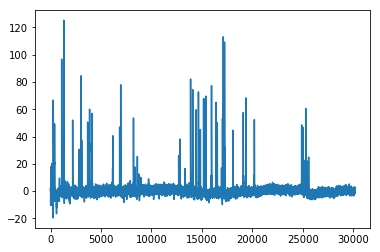

In [3]:
ca_data_path = '/Users/{}/Documents/mouse_bandit/k13_03102017_bandit_8020_neuron_results.mat'.format(user_name)
ca_data = scio.loadmat(ca_data_path,squeeze_me = True, struct_as_record = False)
neuron = ca_data['neuron_results'] # set neuron variable to just contain neuron_results structure

plt.plot(neuron.C_raw[0, :])

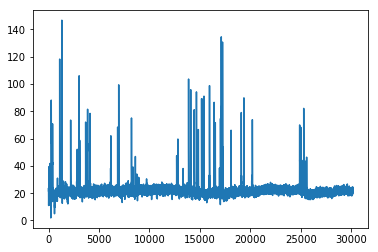

In [4]:
neuron.C_raw = neuron.C_raw-neuron.C_raw.min() # get rid of negative values
plt.plot(neuron.C_raw[0,:])

### dF/F

In [5]:
nNeurons = neuron.C_raw.shape[0]
nFrames = neuron.C_raw.shape[1]

baseline = np.zeros(nNeurons)
dFF = np.zeros_like(neuron.C_raw)
for i in range(nNeurons):
    baseline[i] = np.sort(neuron.C_raw[i,:])[int(np.ceil(0.1*len((neuron.C_raw[i,:]))))]
    dFF[i,:] = (neuron.C_raw[i,:] - baseline[i])/ baseline[i]

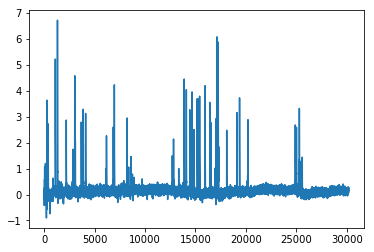

In [6]:
plt.plot(dFF[0,:])

### Normalize/scale

In [7]:
normalized = np.zeros_like(neuron.C_raw)

neuron_min = dFF.min(axis=1)
neuron_max = dFF.max(axis=1)

for i in range(nNeurons):
    normalized[i,:] = (dFF[i,:] - neuron_min[i]) / (neuron_max[i] - neuron_min[i])

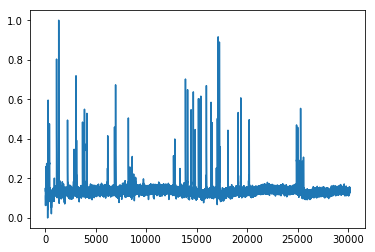

In [8]:
plt.plot(normalized[0,:])

### align to behavioral events

#### load in feature matrix

In [9]:
record_path = '/Users/{}/GitHub/mouse_bandit/session_record.csv'.format(user_name) # session record of behavioral data

record = pd.read_csv(record_path,index_col=0) # session record is panda df

'''Specify mouse and session of interest'''

session_name  = '03102017_K13'
mouse_id = 'k13'

record[record['Session ID'] == session_name] # take only rows from record that match session name


'''Load in trial data from specific session'''

columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
           'Right Reward Prob','Left Reward Prob','Reward Given',
          'center_frame','decision_frame']

root_dir = '/Users/{}/GitHub/mouse_bandit/data/trial_data'.format(user_name)
full_name = session_name + '_trials.csv'

path_name = os.path.join(root_dir,full_name)

trial_df = pd.read_csv(path_name,names=columns)

feature_matrix = bp.create_feature_matrix(trial_df,10,mouse_id,session_name,feature_names='Default',imaging=True)

In [56]:
poke_frames_keys, aligned_start, nTrials = hf.align_frames(feature_matrix, neuron.C_raw, 'decisionPoke', cond1_name='Reward', cond2_name='Decision')
extension = 30
n_variables = 2
conditions = ['Reward', 'Decision']

In [57]:
aligned_start.shape

(139, 91, 42, 4)

In [59]:
n_combos = len(poke_frame_keys)

mean_center_poke = np.zeros((aligned_start.shape[1], nNeurons, n_combos))
sum_center_poke = np.zeros((aligned_start.shape[1], nNeurons, n_combos))

for i in range(n_combos):
    mean_center_poke[:,:,i]= np.nanmean(aligned_start[0:nTrials[i],:,:,i], axis=0)
    sum_center_poke[:,:,i] = np.sum(aligned_start[0:nTrials[i],:,:,i], axis=0)
    


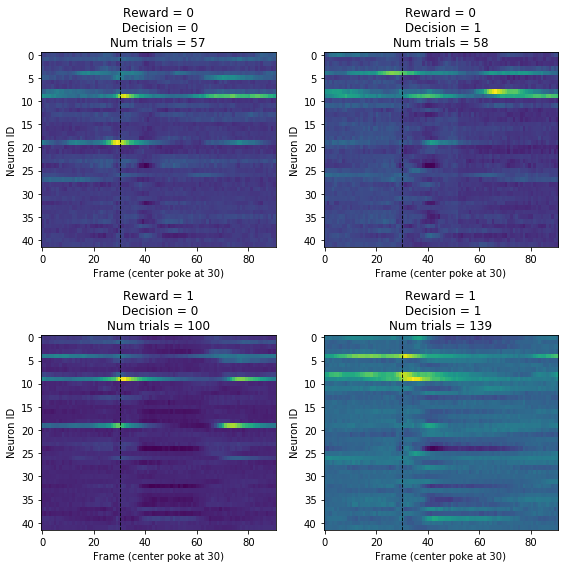

In [62]:
ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_center_poke[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], 
                    conditions[2], poke_frames_keys[i][3], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1], nTrials[i]))
plt.tight_layout()


### recenter neurons using mean

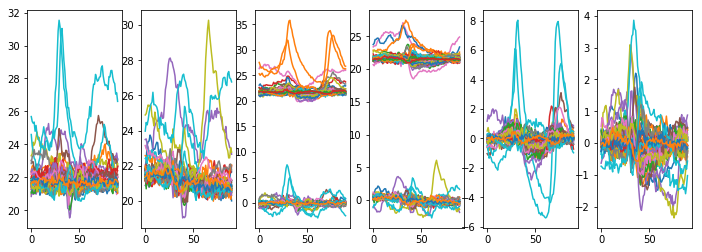

In [63]:
#for i in range(1,(nTrials[0]-2)):
centered = np.zeros_like(mean_center_poke)

plt.figure(figsize=(16,4))
for iCombo in range(n_combos):
    for iNeuron in range(nNeurons):
        plt.subplot(1,n_combos*2,iCombo+1)
        plt.plot(mean_center_poke[:,iNeuron,iCombo])
        centered[:,iNeuron,iCombo] = mean_center_poke[:,iNeuron,iCombo] - np.mean(mean_center_poke[:,iNeuron,iCombo])
        plt.subplot(1,n_combos*2,iCombo+3)
        plt.plot(centered[:,iNeuron,iCombo])

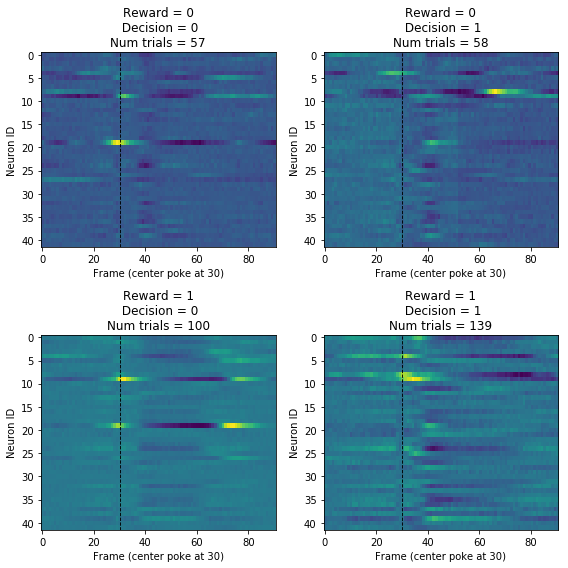

In [64]:
ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(centered[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], 
                    conditions[2], poke_frames_keys[i][3], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1], nTrials[i]))
plt.tight_layout()